In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

In [2]:
file_path1 = 'citigroup.csv'
file_path2 = 'TSM_historical_data.csv'
df_citi = pd.read_csv(file_path1,  index_col='Date', parse_dates=True)
df_tsm = pd.read_csv(file_path2,  index_col='Date', parse_dates=True)
duration = min(df_citi.shape[0], df_tsm.shape[0])

Adjusted close price takes dividends, stock splits, and new stock offerings into account. Typically more accurate in reflecting the stock's true value.
day trader may want to use close price, the actual cash value, while long-term trader may want to use adjusted closing price when assessing the corporate's long-term performance

In [3]:
df_citi = pd.DataFrame(df_citi)[-duration:]
df_tsm = pd.DataFrame(df_tsm)[-duration:]

In [4]:
df_citi = df_citi[-duration:][['Adj Close']]
df_tsm = df_tsm[-duration:][['Adj Close']]

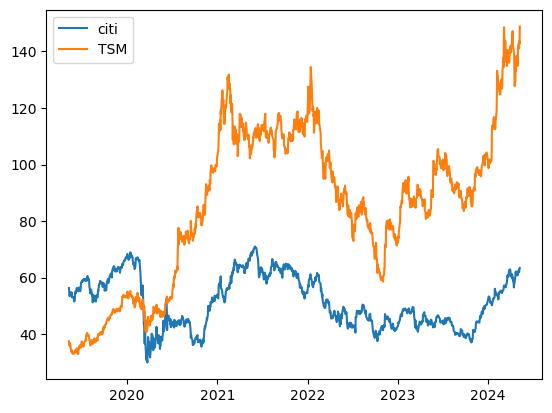

In [5]:
plt.plot(df_citi,label='citi')
plt.plot(df_tsm,label='TSM')
plt.legend()

In [6]:
df_citi.rename(columns={'Adj Close':'Citi Adj Close'}, inplace=True)
df_tsm.rename(columns={'Adj Close':'TSM Adj Close'}, inplace=True)

In [7]:
joined_df = df_citi.join(df_tsm, on='Date')

In [8]:
joined_df.head()

,Citi Adj Close,TSM Adj Close
Date,,
2019-05-10,56.321140,37.501419
2019-05-13,53.401390,35.890339
2019-05-14,54.131340,36.748413
2019-05-15,53.807842,36.748413
2019-05-16,54.728550,36.363152


In [9]:
joined_df.columns

Index(['Citi Adj Close', 'TSM Adj Close'], dtype='object')

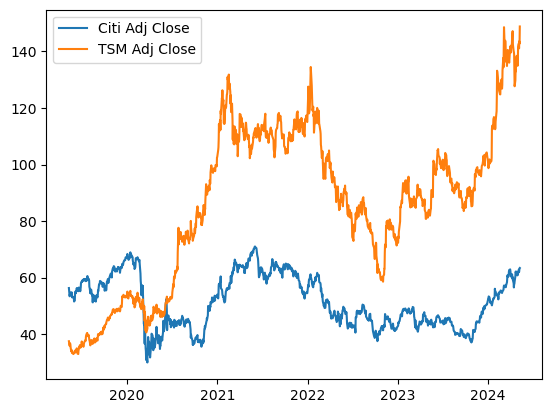

In [10]:
plt.plot(joined_df,label=joined_df.columns)
plt.legend()

Forecast with LSTM

In [11]:
# define a function to split training and testing datasets
def generate_df(df, scaler, nlookback=60, nforecast=10):
    # sc: sklearn.preprocessing object
    # return scaled X, y & scaling
#     ds_to_np = ds.to_numpy()
    X_data, Y_data, Scaler = [], [], []
    target_idx=0
    for i in range(len(df)-nlookback-nforecast):
        dat = np.asarray([j for j in df[i:i+nlookback+nforecast].to_numpy()])#
        scaler_obj = scaler()
#         scaler_obj = MinMaxScaler(feature_range=(0,1))
        scaler_obj.fit(dat)  
        dat = scaler_obj.transform(dat)
        X_data.append([k for k in dat[:nlookback,...]])
        Y_data.append(np.asarray([l for l in dat[nlookback:nlookback+nforecast,...]])[...,target_idx])
        Scaler.append(scaler_obj)
    return np.array(X_data), np.array(Y_data), Scaler

In [12]:
# train-test split
def train_test_split(X,y, Sc, train_frac=0.8):
    # each set contains X, Y and scaler object
    temp1 = int(train_frac**2*len(X))
    temp2 = int(train_frac*len(X))
    
    training_set = [X[:temp1], y[:temp1], Sc[:temp1]]
    validation_set = [X[temp1:temp2,...], y[temp1:temp2,...], Sc[temp1:temp2]]
    test_set = [X[temp2:],y[temp2:], Sc[temp2:]]
    return training_set, validation_set, test_set

In [13]:
n_lookback, n_forecast = 60, 5

In [14]:
X, Y, Scaler = generate_df(joined_df, scaler = StandardScaler, nlookback=n_lookback, nforecast=n_forecast)

In [15]:
train_set, val_set, test_set = train_test_split(X, Y, Scaler)

In [16]:
print(train_set[0].shape, train_set[1].shape)


(764, 60, 2) (764, 5)


In [17]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_set[0].shape[1],train_set[0].shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
# model.add(Dense(8),'relu')
model.add(Dense(n_forecast),'linear')
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,757 (245.14 KB)

 Trainable params: 62,757 (245.14 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
checkpoint = ModelCheckpoint('model.keras', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [19]:
X_train,Y_train = train_set[0], train_set[1]
val_data = (val_set[0],val_set[1])

In [20]:
print(X_train.shape, Y_train.shape)

(764, 60, 2) (764, 5)


In [21]:
history=model.fit(X_train, Y_train, validation_data=val_data, epochs=20, batch_size=32, callbacks=[checkpoint], verbose=1)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.5018 - root_mean_squared_error: 1.2248 - val_loss: 0.7718 - val_root_mean_squared_error: 0.8785
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9898 - root_mean_squared_error: 0.9910 - val_loss: 0.5966 - val_root_mean_squared_error: 0.7724
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5870 - root_mean_squared_error: 0.7660 - val_loss: 0.5008 - val_root_mean_squared_error: 0.7077
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5232 - root_mean_squared_error: 0.7230 - val_loss: 0.3457 - val_root_mean_squared_error: 0.5879
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3826 - root_mean_squared_error: 0.6182 - val_loss: 0.2717 - val_root_mean_squared_error: 0.5213
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.3071 - root_mean_squared_error: 0.5538 - val_loss: 0.2246 - val_root_mean_squared_error: 0.4739
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss:

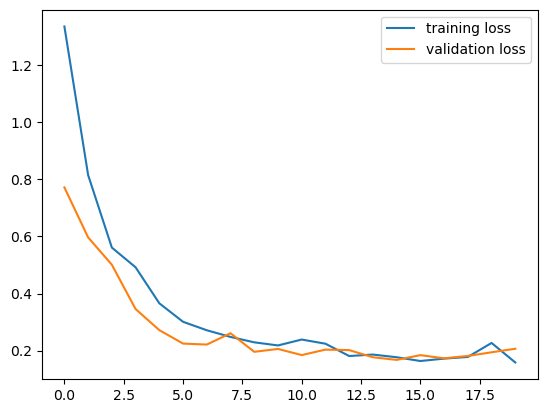

In [22]:
plt.plot(history.history['loss'],label='training loss')
# plt.plot(history.history['val_root_mean_squared_errorloss'])
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

use trained model to make prediction

In [23]:
# load model
model = load_model('model.keras')

In [24]:
test_Xdat = test_set[0]
test_Ydat = test_set[1]

In [70]:
print(test_Xdat.shape, test_Ydat.shape)

(239, 60, 2) (239, 5)


In [27]:
pred_result=model.predict(test_Xdat)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


visualise single prediction

In [30]:
i = 0

In [28]:
nlookback = test_Xdat.shape[1]
nforecast = pred_result.shape[1]

In [31]:
test_X=Scaler[i].inverse_transform(test_Xdat[i])[...,0]

In [61]:
np.repeat(test_Ydat[i].reshape(-1,1),test_Xdat.shape[2], axis=1)[...,0]

array([-0.32317949, -0.97638088, -1.09598153, -0.9257817 , -0.87978105])

In [62]:
test_Y=Scaler[i].inverse_transform(np.repeat(test_Ydat[i].reshape(-1,1), test_Xdat.shape[2], axis=1))[...,0]
predicted_Y = Scaler[i].inverse_transform(np.repeat(pred_result[i].reshape(-1,1), test_Xdat.shape[2], axis=1))[...,0]

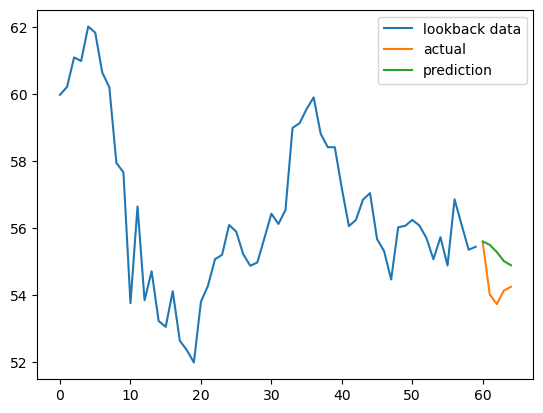

In [69]:
plt.plot(np.arange(nlookback), test_X, label='lookback data')
plt.plot(np.arange(nlookback,nlookback+nforecast),test_Y,label='actual')
plt.plot(np.arange(nlookback,nlookback+nforecast),predicted_Y,label='prediction')
plt.legend()

random plot

In [80]:
# plot predictions over actual
n1, n2 = 4, 4 # number of subplots per row and col
subplot_n=n1*n2

[ 73 205  87 196 163  83 193 153  61 155  34 126  74  52 203  12]


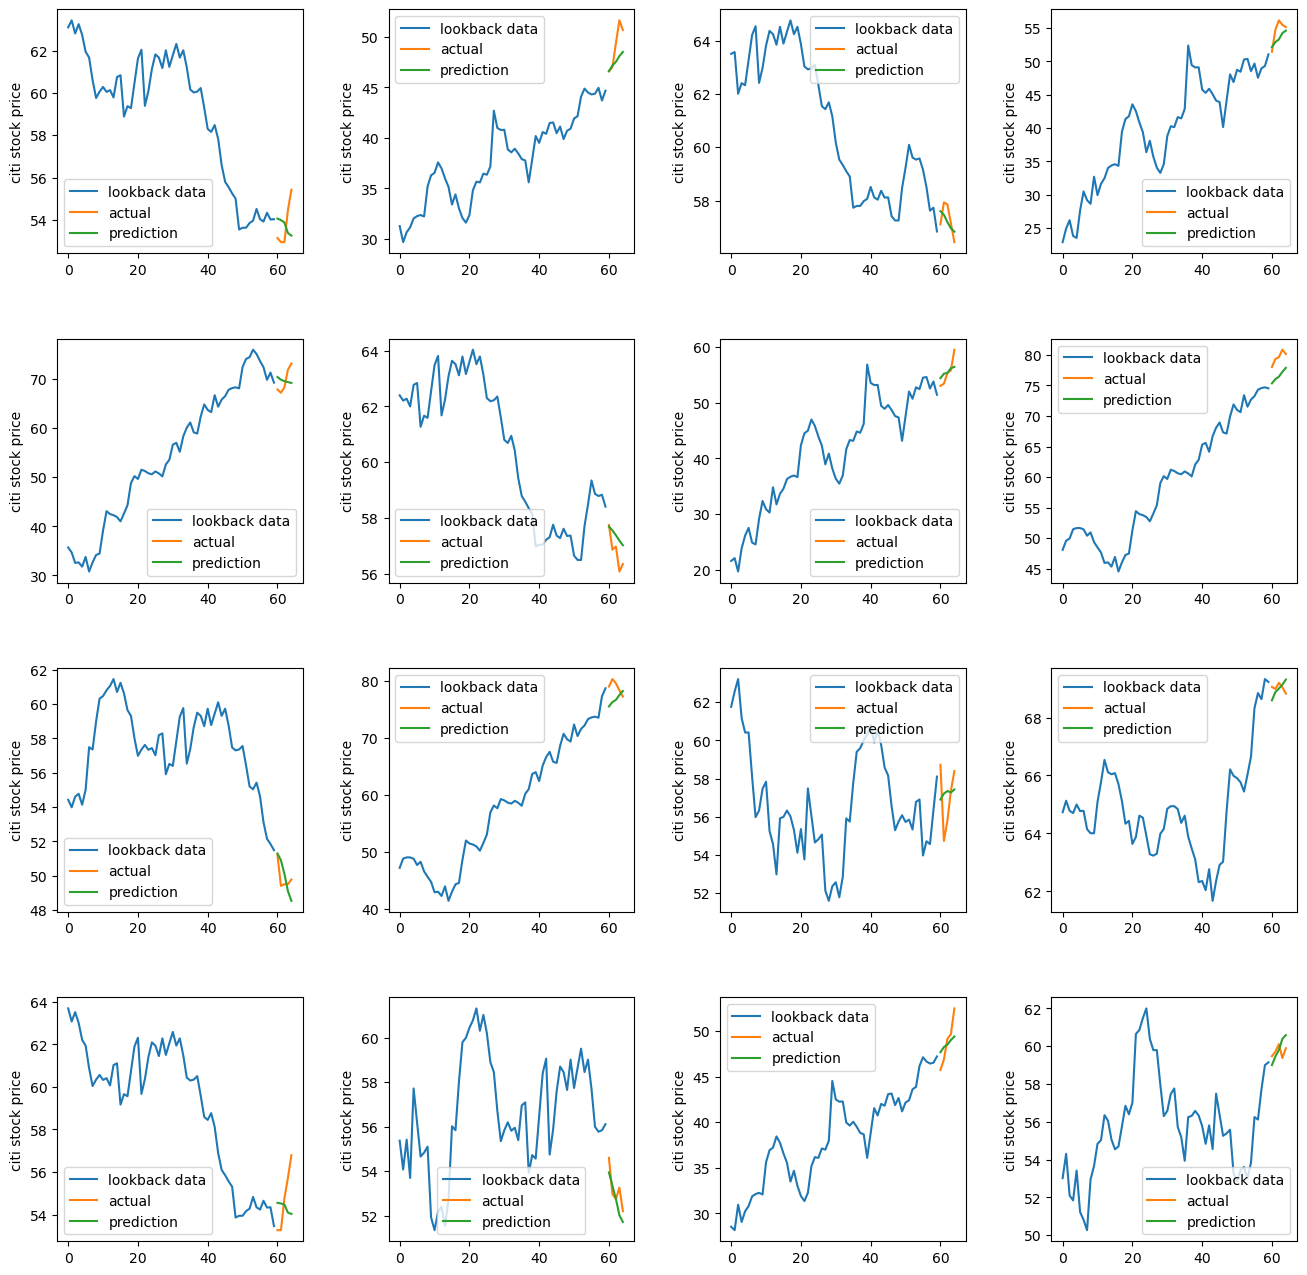

In [93]:
fig, ax = plt.subplots(figsize=(4*n2,4*n1),nrows=n1,ncols=n2)
dim = test_set[0].shape[0]
idx = np.random.randint(dim, size=(n1,n2)).flatten()
print(idx)

for j,ax in zip(idx,ax.flatten()):
    test_Xdata = Scaler[j].inverse_transform(test_Xdat[j])[...,0]
    test_Ydata=Scaler[j].inverse_transform(np.repeat(test_Ydat[j].reshape(-1,1), test_Xdat.shape[2], axis=1))[...,0]
    predicted_Y = Scaler[j].inverse_transform(np.repeat(pred_result[j].reshape(-1,1), test_Xdat.shape[2], axis=1))[...,0]
    ax.plot(np.arange(nlookback), test_Xdata, label='lookback data')
    ax.plot(np.arange(nlookback,nlookback+nforecast),test_Ydata,label='actual')
    ax.plot(np.arange(nlookback,nlookback+nforecast),predicted_Y,label='prediction')
    ax.legend()
    ax.set_ylabel('citi stock price')

fig.subplots_adjust(wspace=0.35)
fig.subplots_adjust(hspace=0.35)